Notebook to compute the eigenmode decomposition of 1D diffusion utilizing 
random walk methodology. Used to validate modal markov formulation for calcium
diffusion. Simple 1d diffusion with no reactions.

11 nodes.

author: Margot Wagner
date created: 6/16/22

### setup

In [8]:
import numpy as np
from numpy.linalg import eig
import matplotlib.pyplot as plt
import math
from typing import Union, Tuple

In [9]:
# constants
# create mesh
n_spatial_locs = 11  # define number of grid points along 1D line
dt = 1  # time step (usec)
n_time_pts = 1000  # number of time points

particle_start_loc = 5  # starting position for molecules
min_loc = 0  # minimum position
max_loc = n_spatial_locs - 1  # maximum position
last_elem_i = -1  # index for the last element in a list

line_length = 4  # total length of diffusion line (um)
n_particles = 50  # number of molecules
diffusion_constant_D = 2.20e-4  # Calcium diffusion coeff (um^2/usec)

### 1D Random Walk Diffusion Simulation

(implementation similar to GeeksforGeeks' ["Random Walk (Implementation in Python)"](https://www.geeksforgeeks.org/random-walk-implementation-python/))

Import diffusion functions from companion notebook:

In [10]:
import import_ipynb
from RandomWalk1dSimulation import get_jump_probability, random_walk_simulation, random_walk_postprocess

# Eigenmode Markov Model

## Transition Matrix
<div>

</div>

Given the diffusion constant $D$, we calculate the rate constant  $k$ as 

$k = \frac{D}{dx^2}$,

where $dx$ is the distance between spatial nodes.

This leads us to the transition matrix $A$:

$ A = \begin{bmatrix} 
 -k &   k &   0 &   0 &  0 & \ldots &   0 \\
  k & -2k &   k &   0 &  0 & \ldots &   0 \\
  0 &   k & -2k &   k &  0 & \ldots &   0 \\
  0 &   0 &   k & -2k &  k & \ldots &   0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots\\
  0 &   0 &   0 &   0 &  k &    -2k &   k \\
  0 &   0 &   0 &   0 &  0 &      k &  -k \\
\end{bmatrix}
$

In [46]:
def transition_matrix_maker(
    diffusion_rate_constant_k: Union[int,float], 
    n_spatial_locs: int
    ) -> np.ndarray:
    """Builds and returns the transition matrix for the 1D random walk case 
    as given.

    params:
        diffusion_rate_constant_k:
            jump rate constant
        n_spatial_locs:
            number of grid points along line

    returns:
        transition matrix
    """

    # Define A (transition) matrix
    A = np.zeros(
        (n_spatial_locs, n_spatial_locs)
    )  # transition probability between grid points

    # Transition matrix is given by the ODE dynamics equation (using k-values)
    vec_diag = np.full(n_spatial_locs, (-2 * diffusion_rate_constant_k))
    
    vec_off_diag = np.full(
        (n_spatial_locs - 1), diffusion_rate_constant_k
    )  # off-diagonal values
    
    # create transition matrix
    A = (
        np.diag(vec_diag, k=0)        # k=0 is the main diagonal
        + np.diag(vec_off_diag, k=1)  # k>0 is above the main diagonal
        + np.diag(vec_off_diag, k=-1) # k<0 is below the main diagonal
    )
    
    # modify first and last diagonal entries
    A[0, 0] = -diffusion_rate_constant_k
    A[n_spatial_locs - 1, n_spatial_locs - 1] = -diffusion_rate_constant_k

    return A

### Compute rate constant and $A$
Why do we flip the rate constant $k$'s sign here?

P(jump) = 0.00166375
k=0.00166375/us


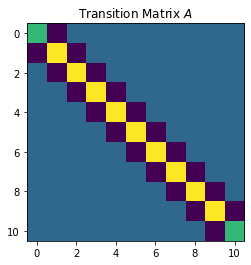

In [48]:
# find probability of moving one step
jump_probability, jump_rate_constant_k = get_jump_probability(
    line_length, n_spatial_locs, diffusion_constant_D, dt
)
print('P(jump) = {}\nk={}/us'.format(jump_probability, jump_rate_constant_k))

# build transition matrix
A = transition_matrix_maker(-jump_rate_constant_k, n_spatial_locs)
plt.imshow(A)
plt.title('Transition Matrix $A$')
plt.show()

### Compute eigenvalues/vectors of $A$
We find the eignevalues and eigenvectors of the transition matrix $A$.

In [38]:
def get_eigenvalues_and_vectors(A: np.ndarray, 
                                print_output=True, 
                                plot_eigenmodes=False
                                ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Returns the sorted eigenvalues and eigenvectors of matrix A

    Args:
        A: transition matrix

    Returns:
        eigenvalues: 1d matrix of size n_spatial_locs
        eigenvectors: 2d matrix of eigenvectors where columns
                correspond to eigenvalues (ie evec[:,k] <-> eval[k])
        eval_sort_index: argsort index array used to sort eigenvalues.
                Can be used to sort via matrix[eval_sort_index]

    """

    # get eigenvalues/eigenvectors
    # eigenmode[k] is composed of eigenvector[:, k] and eigenvalue[k]
    e_val_unsorted, e_vec_unsorted = eig(A)
    np.set_printoptions(suppress=True)  # gets rid of scientific notation
    
    # sort values and vectors
    eigenvalues = np.sort(e_val_unsorted)
    eval_sort_index = np.argsort(e_val_unsorted)
    eigenvalues[0] = round(eigenvalues[0])
    eigenvectors = e_vec_unsorted[:, eval_sort_index]
    
    # normalize eigenvector values
    eigenvectors = eigenvectors / eigenvectors[0, 0]

    if print_output:
        print("EIGENVALUES")
        print(" ", end="")
        [print(i, end=" " * 5) for i in range(n_spatial_locs)]
        print()
        print(eigenvalues.round(decimals=3))
        print()
        
        print("EIGENVECTORS")
        # eigenvector columns correspond to eigenvalues 
        # (ie evec[:,k] <-> eval[k])
        print("   ", end="")
        [print(i, end=" " * 4) for i in range(n_spatial_locs)]
        print()
        print(eigenvectors.round(decimals=1))
        print()

    if plot_eigenmodes:
        print("EIGENMODES (e^(-eigenvalue * t))")
        ## TODO: ADD LEGEND
        plot_eigenmodes(eigenvalues)

    return eigenvalues, eigenvectors, eval_sort_index

In [39]:
# get sorted eigenvalues and eigenvectors (normalized)
eigenvalues, eigenvectors, eval_sort_index = get_eigenvalues_and_vectors(
    A, 
    #print_output=False, plot_eigenmodes=False
)

EIGENVALUES
 0     1     2     3     4     5     6     7     8     9     10     
[0.    0.    0.001 0.001 0.002 0.003 0.004 0.005 0.006 0.006 0.007]

EIGENVECTORS
   0    1    2    3    4    5    6    7    8    9    10    
[[ 1.   1.4  1.4 -1.3 -1.2 -1.1 -0.9 -0.8 -0.6  0.4  0.2]
 [ 1.   1.3  0.9 -0.4  0.2  0.8  1.2  1.4  1.4 -1.1 -0.6]
 [ 1.   1.1  0.2  0.8  1.4  1.3  0.6 -0.4 -1.2  1.4  0.9]
 [ 1.   0.8 -0.6  1.4  0.9 -0.4 -1.4 -1.1  0.2 -1.3 -1.2]
 [ 1.   0.4 -1.2  1.1 -0.6 -1.4 -0.2  1.3  0.9  0.8  1.4]
 [ 1.  -0.  -1.4 -0.  -1.4  0.   1.4  0.  -1.4  0.  -1.4]
 [ 1.  -0.4 -1.2 -1.1 -0.6  1.4 -0.2 -1.3  0.9 -0.8  1.4]
 [ 1.  -0.8 -0.6 -1.4  0.9  0.4 -1.4  1.1  0.2  1.3 -1.2]
 [ 1.  -1.1  0.2 -0.8  1.4 -1.3  0.6  0.4 -1.2 -1.4  0.9]
 [ 1.  -1.3  0.9  0.4  0.2 -0.8  1.2 -1.4  1.4  1.1 -0.6]
 [ 1.  -1.4  1.4  1.3 -1.2  1.1 -0.9  0.8 -0.6 -0.4  0.2]]



### Eigenmodes of $A$
For each eigenvalue $\lambda$, the corresponding eigenmode is just the decay exponential $e^{-\lambda t}$

In [40]:
def get_eigenmode(eigenvalues, t):
    return np.exp(-eigenvalues * t)

In [41]:
def plot_eigenmodes(eigenvalues):
    time = np.array(range(n_time_pts))

    for i in range(len(eigenvalues)):
        plt.plot(time, get_eigenmode(eigenvalues[i], time))

    plt.xlabel('time [us]')
    plt.ylabel('eigenmode amplitude')
    plt.show()

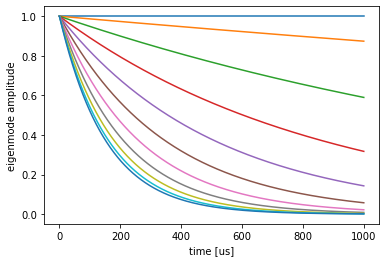

In [42]:
plot_eigenmodes(eigenvalues)

## Initial Conditions

When the particle is placed at node $x$, initial conditions are given by:
\begin{equation} 
    m_{\pm k} = \frac{1}{2} \left( 1 \pm \frac{n_{x, t_0} \text{v}_{x k}}{\sqrt{n_{x, t_0} (\text{v}_{x k})^2}} \right)
\end{equation}

where $n_{x, t_0}$ captures the total number of particles. 

For number of nonzero particles $n_{x, t_0}$ = 1 then particle initial conditions can be described by a constant, the
total number of particles $C$:
\begin{equation} 
    m^\circ_{\pm k} = \frac{1}{2} \left( \sqrt{C (\text{v}^\circ_{ k})^2} \pm C \text{v}^\circ_{k} \right)
\end{equation}

$v^\circ_k$ is the eigenvector associated with the spatial node that the particles were initial input to. 

\begin{equation} 
    m_{\pm k} = \frac{v^\circ_k}{2} \left( \sqrt{C} \pm C \right)
\end{equation}

In [13]:
def eigenmode_init_conditions(
    eigenvectors: np.ndarray, 
    eval_sort_index: np.ndarray, 
    print_output=True
) -> Tuple[np.ndarray, np.ndarray]:
    """Find the initial normalized number of particles in the positive 
    and negative state of eigenmode k

    params:
        eigenvectors:
            eigenvector columns correspond to eigenvalues 
            (ie evec[:,k] <-> eval[k])
            eigenvector[e, eigenmode (k)]

    return:
        normalized number of particles in each eigenmode at time = 0
    """

    # starting loc given by particle_start_loc

    # new index of starting node location in sorted eigenvalue/vector arrays
    start_loc_eigenvalue_i = np.where(eval_sort_index == particle_start_loc)

    # get eigenvector for starting location, all eigenmodes (v^\circ_k)
    start_loc_eigenvector = eigenvectors[start_loc_eigenvalue_i, :]

    # variable fraction component of initial conditions equation
    '''
    fraction_value = (n_particles * start_loc_eigenvector) / (
        np.sqrt(n_particles * (start_loc_eigenvector**2))
    )
    '''
    # NOTE: INITIAL CONDITIONS ARE NEGATIVE IF N_TOTAL_PARTICLES IS NOT SQUARED....
    # NEEDS TO BE SQUARED TO MATCH EQUATIONS WHRE N_TOTAL_PARTICLES IS TAKEN OUT OF EQTN
    fraction_value = (n_particles * start_loc_eigenvector) / (
        np.sqrt(n_particles**2 * (start_loc_eigenvector**2))
    )
    

    n_per_positive_mode = (1 + fraction_value) / 2
    n_per_negative_mode = (1 - fraction_value) / 2

    if print_output:
        print("EIGENMODE INITIAL CONDITIONS")
        print("POSITIVE")
        print(n_per_positive_mode)
        print("NEGATIVE")
        print(n_per_negative_mode)
        print()

    return n_per_positive_mode, n_per_negative_mode

Transition probability given by 

\begin{equation} 
    P(transition_{\pm k \rightarrow \mp k}) = \frac{\lambda}{2} dt 
\end{equation}

where $\lambda$ is the eigenVALUE (not eigenvector or eigenmode)

In [14]:
def get_eigenmode_transition_probability(
    eigenvalues: np.ndarray, 
    print_output=True
    ) -> np.ndarray:

    transition_probability = (eigenvalues / 2) * dt

    if print_output:
        print("EIGENMODE TRANSITION PROBABILITIES")
        [print(i, end="\t") for i in range(n_spatial_locs)]
        print()
        [
            print("{:0.1e}".format(transition_probability[i]), end=" ")
            for i in range(n_spatial_locs)
        ]
        print()

    return transition_probability

In [15]:
def eigenmode_markov_simulation(
    n_eigenmodes: int,
    init_cond: np.ndarray,
    transition_probability: np.ndarray,
    n_particles: int,
    dt: Union[int, float],
    n_time_pts: int,
    plot=False,
) -> np.ndarray:
    """Markov simulation for eigenmode analysis to capture calcium diffusion 
    over time
    
    params:
        n_eigenmodes:
            number of modes (k not +/- k); equal to number of locations 
            (n_spatial_loc)
        init_cond:
            initial distribution of particles between positive and negative 
            eigenmode states; [positive vector, negative vector]
        transition_probability:
            probability of transitioning between + and - eigenmode states
        n_particles:
            number of particles
        dt:
            timestep
        n_time_pts:
            number of timepoints

    return:
        n_per_eigenmode_state: normalized number of particles in each 
        eigenmode (+/-) at each timepoint
        np aray shape (n_modes x n_time x n_eigenmode_states)
    """
    # positive and negative states
    n_eigenmode_states = 2

    # initialize number of particles
    # n_modes x n_time x n_eigenmode_states (for +/-, this is 2)
    n_per_eigenmode_state = np.zeros(
        (n_spatial_locs, n_time_pts, n_eigenmode_states)
    ).astype("int")

    # assign initial conditions using number of molecules
    for j in range(n_eigenmode_states):
        n_per_eigenmode_state[:, 0, j] = init_cond[j]

    # for each time point
    for i in range(n_time_pts - 1):

        # for each eigenmode
        for k in range(n_spatial_locs):

            # initialize the number of particles that transition
            # [from + -> -, from - -> +]
            n_change = [0, 0]

            # find number of transitions positive/negative eigenmode state;
            for j in range(n_eigenmode_states):

                # sample random numbers equal to number of particles in 
                # current state
                r = np.random.random(n_per_eigenmode_state[k, i, j])

                # sum number of particles that transitioned
                n_change[j] = sum(r < transition_probability[k])

            # update next time point
            for j in range(n_eigenmode_states):
                n_per_eigenmode_state[k, i + 1, j] = (
                    n_per_eigenmode_state[k, i, j]
                    - n_change[j]
                    + n_change[1 - j]
                )

    if plot:
        n_plot_columns = 2
        n_plot_rows = math.ceil(n_spatial_locs / n_plot_columns)
        fig, ax = plt.subplots(n_plot_columns, n_plot_rows, figsize=(14, 10))

        m_count = 0
        for i in range(n_plot_columns):
            for j in range(n_plot_rows):
                for k in range(n_eigenmode_states):
                    if m_count < n_spatial_locs:
                        ax[i, j].plot(
                            list(range(n_time_pts)),
                            n_per_eigenmode_state[m_count, :, k],
                        )
                        ax[i, j].set_title("Eigenmode {}".format(m_count))

                m_count += 1

        # fig.suptitle
        fig.tight_layout()
        plt.show()

    return n_per_eigenmode_state

To transform the <u>number</u> of particles in each eigenmode to the <u>number</u> at each spatial location, we use the following equation:

\begin{equation} 
\begin{split}
    n_i = \sum_k \text{v}_{ik} m_k \\
    = \sum_k \text{v}_{ik} \left( m_{+k} - m_{-k} \right)
\end{split}
\end{equation}





In [16]:
def eigenmodes_to_spatial_nodes(
    n_per_eigenmode_state: np.ndarray, 
    eigenvectors: np.ndarray,
    print_output=True
    ) -> np.ndarray:
    """Calculate the number of particles at each node from the eigenmode 
    representation.

    Args:
        n_per_eigenmode_state: normalize the number of particles in each node;
        np aray shape (n_modes x n_time x n_eigenmode_states)
        eigenvectors: eigenvector of node i (vector); v[:,k] is the eigenvector
        corresponding to the eigenvalue w[k]; (ie evec[:,k] <-> eval[k])
            eigenvector[e, eigenmode (k)]


    Returns:
        np array containing normalized particle counts for each node 
        (n_nodes x n_time_pts)
    """

    # initialize node values (n_nodes x n_time_pts)
    node_vals_from_modes = np.zeros((n_spatial_locs, n_time_pts))
    
    # positive - negative
    n_per_eigenmode = (n_per_eigenmode_state[:,:,0] - n_per_eigenmode_state[:,:,1])
    

    for i in range(n_spatial_locs):
        evector_node_i = eigenvectors[:, i].reshape((n_spatial_locs, 1))
        
        # inverse transform
        node_vals_from_modes[i, :] = np.sum((evector_node_i * n_per_eigenmode), axis=0)
        
             
    if print_output:
        import math
        print("COUNT PER SPATIAL NODE (FROM EIGENMODES) (N_NODES x TIME)")
        print("PRINTING SIMULATION TIME POINTS SEPARATED BY 100 TIME POINTS")
        for i in range(n_spatial_locs):
            print(i, end="\t")
            print(node_vals_from_modes[i,0:n_time_pts:math.ceil(n_time_pts/14)].round(decimals=1))
        print()
    

    return node_vals_from_modes

In [17]:
def graph_num_comparison(
    n1: np.ndarray, 
    n2: np.ndarray, 
    legend_vals=[], 
    title="",
    normalize=True
    ):
    
    """Graph comparing normalized number of particles at each node 
    and in each mode.

    Args:
        n1: normalized number of particles in one condition 
        (particles per time)
        n2: normalized number of particles in one condition 
        (particles per time)
    """
    import math
    half_n_nodes = math.ceil(n1.shape[0] / 2)

    fig, axes = plt.subplots(half_n_nodes, 2, figsize=(14, 10))
    
    if normalize:
        n1 = n1 / n_particles
        n2 = n2 / n_particles

    for i, ax in enumerate(axes.flat):
        if i == n_spatial_locs:
            break
        ax.axhline(y=0, color='black', linestyle='--')
        ax.plot(list(range(n_time_pts)), n1[i, :])
        ax.plot(list(range(n_time_pts)), n2[i, :])
        ax.legend(legend_vals)
        ax.set_title("{} {}".format(title, i))

    fig.tight_layout()
    plt.show()
    
    print("{} PARTICLES STARTED NODE {}".format(n_particles, particle_start_loc))
    print("NORMALIZATION TURNED ON? \t", normalize)

### Main

In [36]:
def main():

    # run diffusion simulation (baseline, without using Markov modeling)
    particle_locs = random_walk_simulation(
        n_particles, n_time_pts, jump_probability
    )

    # plot output
    unnorm_n_per_loc, n_per_loc, mean_n_per_loc = random_walk_postprocess(
        particle_locs, plot=False
    )
    
    # Find initial values for the number of particles in each eigenmode
    # For n_particles = 1, it should just be 1 and 0 respectively
    init_n_positive_modes, init_n_negative_modes = eigenmode_init_conditions(
        eigenvectors, eval_sort_index
    )

    # initialize eigenmode Markov model transition probabilities
    eigenmode_transition_probability = get_eigenmode_transition_probability(
        eigenvalues, print_output=True
    )

    # run Markov model
    n_per_eigenmode_state = eigenmode_markov_simulation(
        n_spatial_locs,
        [init_n_positive_modes, init_n_negative_modes],
        eigenmode_transition_probability,
        n_particles,
        dt,
        n_time_pts,
        plot=False,
    )
    
    
    # inverse transform; convert eigenmode representation to node representation
    node_vals_from_modes = eigenmodes_to_spatial_nodes(n_per_eigenmode_state, eigenvectors, print_output=True)
    
    # compare with random walk simulation
    graph_num_comparison(
        n_per_loc, 
        node_vals_from_modes,
        legend_vals=["random walk nodes", "eigenmode nodes"], 
        title="Node"
        )

if __name__ == "__main__":
    tables_created = main()

NameError: name 'particle_start_loc' is not defined